In [24]:
%matplotlib inline

In [25]:
import numpy as np
from nighres import io
import pandas as pd
import gdist
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats

In [26]:
df = pd.read_csv('/home/julia/workspace/mouse_gradients/regions.csv')

In [27]:
data_dir = '/home/julia/data/gradients/'

In [28]:
mesh = io.load_mesh(data_dir + 'allen_atlas/annot_finest_sampled_mesh.vtk')
gradients = io.load_mesh(data_dir + 'results/embedding/embed_sampled_mesh.vtk')['data'][:,:6]
cortex = np.load(data_dir+'results/null_models/surface/cortex_mask.npy')

### Function to separate surface mesh patches

In [6]:
def subcluster_graph(nodes, triangles, clustering):

    # initiate empty graph
    G=nx.Graph()

    # add node indices
    G.add_nodes_from(range(len(nodes)))

    # add edges
    G.add_edges_from(triangles[:,[0,1]])
    G.add_edges_from(triangles[:,[0,2]])
    G.add_edges_from(triangles[:,[1,2]])

    # make an array with one column per cluster, 0 if this node is not in the respective subcluster
    # otherwise number of the sublcuster, therefore, the subclusters have to be one-indexed
    subclust_arr = np.zeros((clustering.shape[0], int(clustering.max()+1)))
    #for each cluster
    for nclust in range(int(clustering.max()+1)):
        # make a subgraph only containing nodes from this cluster
        clustgraph = nx.subgraph(G, np.where(clustering==nclust)[0])
        # find the seperate connected components of this subgraph
        subclust = nx.connected_components(clustgraph)

        count = 0
        for i in subclust:
            for j in i:
                subclust_arr[j][nclust] = count+1
            count += 1

    return subclust_arr

### Calculate center of mass of primary sensory regions

In [7]:
patches = np.zeros_like(mesh['data'])
center_data = np.zeros_like(mesh['data'])
#for a in ['SSp-bfd', 'SSp-m']:
#    idx = df.loc[df['acronym'] == a, 'id'].values[0]
#    patches[np.round(mesh['data'])==idx] = 1
#sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
#patch_a = np.hstack((np.where([sub_patches[:,1]==1])[1], np.where([sub_patches[:,1]==2])[1]))
#patch_b = np.hstack((np.where([sub_patches[:,1]==3])[1], np.where([sub_patches[:,1]==4])[1]))

for a in ['SSp-n','SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-ul', 'SSp-tr', 'SSp-un']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches[np.round(mesh['data'])==idx] = 1
sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
patch_a = np.where([sub_patches[:,1]==1])[1]
patch_b = np.where([sub_patches[:,1]==2])[1]

for patch in [patch_a, patch_b]:
    x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
    y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
    z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
    center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
    center_data[center] = 1
    
for a in ['VISp', 'AUDp']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches = np.zeros_like(mesh['data'])
    patches[np.round(mesh['data'])==idx] = 1
    sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
    patch_a = np.where([sub_patches[:,1]==1])[1]
    patch_b = np.where([sub_patches[:,1]==2])[1]

    for patch in [patch_a, patch_b]:
        x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
        y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
        z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
        center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
        center_data[center] = 1

io.save_mesh(data_dir + 'results/sensory_distance/sensory_centers.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':center_data})

### Calculate distance from these centers

In [11]:
source = np.where(center_data==1)[0]
dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                           np.array(mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros_like(mesh['data'])
dist_mesh[cortex] = dist[:,np.newaxis]
io.save_mesh(data_dir + 'results/sensory_distance/sensory_centers_dist.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

### Compare distance maps with 6 gradients

In [29]:
dist_mesh = io.load_mesh(data_dir + 'results/sensory_distance/sensory_centers_dist.vtk')['data']

Gradient 1: Spearman r=-0.16, p=3.8750
Gradient 2: Spearman r=0.53, p=0.0324
Gradient 3: Spearman r=0.22, p=1.8412
Gradient 4: Spearman r=-0.34, p=1.3673
Gradient 5: Spearman r=0.56, p=0.0534
Gradient 6: Spearman r=-0.23, p=1.6144


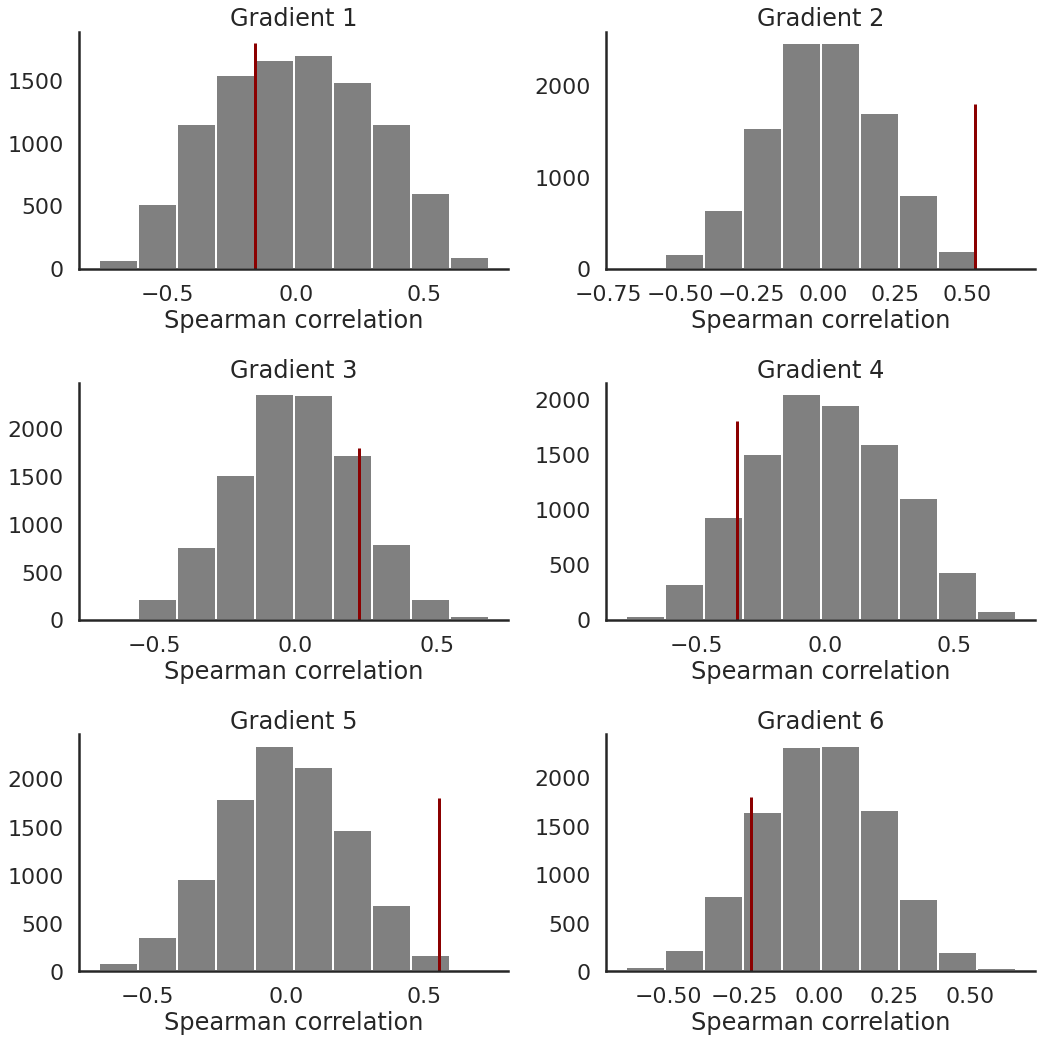

In [45]:
sns.set_style('white')
sns.set_context('poster')
fig = plt.figure(figsize=(15,15))

for g in range(6):
    rs = []
    surrogates = np.load(data_dir + 'results/null_models/surface/surrogates/surf{}_surrogates.npy'.format(g))
    for s in range(10000):
        r, _ = stats.spearmanr(surrogates[s,:], dist_mesh[cortex])
        rs.append(r)
    r, _ = stats.spearmanr(gradients[:,g][cortex], dist_mesh[cortex])
    p = np.where(np.abs(rs)>=np.abs(r))[0].shape[0] / (len(rs)+1) * 6
    print('Gradient {}: Spearman r={:.2f}, p={:.4f}'.format(g+1, r, p))
    
    fig.add_subplot(3,2,g+1)
    plt.hist(rs, color='grey', label='Surrogate maps')
    plt.vlines(r, 0,1800, color='darkred', label='Gradient {}'.format(g+1))
    plt.xlabel('Spearman correlation')
    plt.title('Gradient {}'.format(g+1))
    sns.despine()
plt.tight_layout()

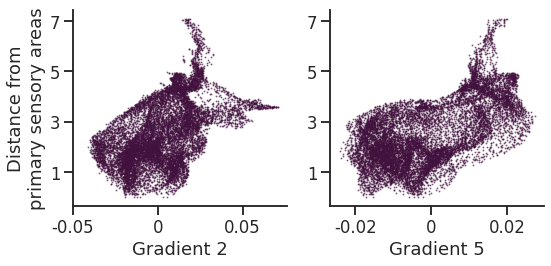

In [31]:
sns.set_style('ticks')
sns.set_context('talk')
#c = 'darkslategray'
#|c = 'rosybrown'
c=(0.25999463887892144, 0.07005385560386188, 0.24308218808684579)
#c=(0.24688226237959, 0.06905363944920445, 0.31786993834254956)


dist_mesh = np.squeeze(dist_mesh)
fig = plt.figure(figsize=(8, 4))

g=1
fig.add_subplot(1,2,1)
sns.regplot(gradients[:,g][cortex], dist_mesh[cortex], 
            fit_reg=False,
            line_kws={'color':'black', 'linewidth':2, 
                      'linestyle':'--', 'alpha':0.7},
            scatter_kws={'alpha':0.5, 's':1, 'color':c}, 
            truncate=True)
plt.xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
plt.yticks([1000, 3000, 5000, 7000], [1, 3, 5, 7])
plt.xlabel('Gradient {}'.format(g+1))
plt.ylabel('Distance from\nprimary sensory areas')
sns.despine()

g=4
fig.add_subplot(1,2,2)
sns.regplot(gradients[:,g][cortex], dist_mesh[cortex], 
            fit_reg=False,
            line_kws={'color':'black', 'linewidth':2,
                     'linestyle':'--', 'alpha':0.7},
            scatter_kws={'alpha':0.5, 's':1, 'color':c}, 
            truncate=True)
plt.xticks([-0.02, 0, 0.02], [-0.02, 0, 0.02])
plt.yticks([1000, 3000, 5000, 7000], [1, 3, 5, 7])
plt.xlabel('Gradient {}'.format(g+1))
sns.despine()

plt.tight_layout()
plt.savefig('/home/julia/Documents/projects/mouse_gradients/sensory_dist_scatter.png')